In [1]:
# dia 20 Adaptive median spatial filtering
import numpy as np

def adpmedian(g, Smax):
    """
    Perform adaptive median filtering on image g (maximum neighbourghood size = Smax).
    """
    y, x = g.shape
    f = np.zeros((y, x), dtype=np.uint8)
    
    for i in range(y):
        for j in range(x):
            Sxy = 3
            while Sxy <= Smax:
                window = img[max(0, i-Sxy//2):min(y, i+Sxy//2+1),
                              max(0, j-Sxy//2):min(x, j+Sxy//2+1)]
                Zmed = np.median(window)
                Zmax = np.max(window)
                Zmin = np.min(window)
                Zxy = img[i, j]
                
                A1 = Zmed - Zmin
                A2 = Zmed - Zmax
                
                if A1 > 0 and A2 < 0:
                    B1 = Zxy - Zmin
                    B2 = Zxy - Zmax
                    if B1 > 0 and B2 < 0:
                        # output Zxy
                        f[i, j] = Zxy
                    else:
                        f[i, j] = Zmed
                    break
                else:
                    # increase window size
                    Sxy += 1
            else:
                f[i, j] = Zmed
    return f
    

C:\Users\Jakob\AppData\Local\Temp\ipykernel_13380\2302853534.py:27: RuntimeWarning: overflow encountered in ubyte_scalars
  B2 = Zxy - Zmax


Text(0.5, 1.0, 'Filtered with function')

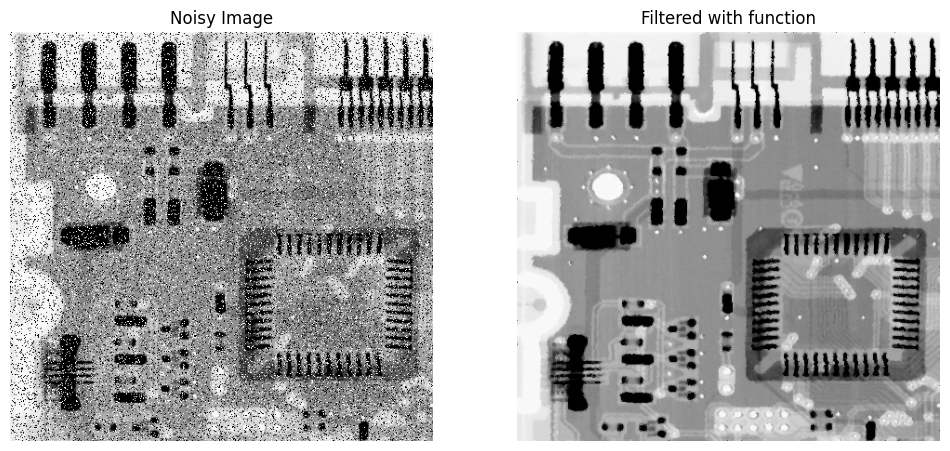

In [2]:
# Test of Adaptive median spatial filtering
import cv2
from skimage.util.noise import random_noise
from matplotlib import pyplot as plt

img = cv2.imread('./imgs/ckt-board-saltpep.tif', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
ax = axs.ravel()
[axi.set_axis_off() for axi in ax.ravel()]

ax[0].imshow(img, cmap='gray', vmin = 1.0, vmax = 255)
ax[0].set_title('Noisy Image')

filtered = adpmedian(img, 9)

ax[1].imshow(filtered, cmap='gray', vmin = 1.0, vmax = 255)
ax[1].set_title('Filtered with function')

In [11]:
# dia 29 Custom periodic_noise function

from scipy import signal

def periodic_noise(shape, C, A = None, B = None):
    """
    Generate periodic noise arrays (r:spatial domain, R:frequency domain).
    shape:shape of array
    C: (K,2)array of energy burst frequencies
    A: (K,)vector of burst magnitudes
    B: (K,2)array of phase shifts (Bx,By)
    """
    
    M, N = shape
    
    # K = pairs of freq domain coordinates (u,v)
    K = C.shape[0]
    
    if A is None:
        A = np.ones((K,))
        B = np.zeros((K, 2))
        B[1:K, 0:2] = 0
    if B is None:
        B = np.zeros((K, 2))
        B[1:K, 0:2] = 0
    
    u, v = np.mgrid[:M,:N].astype('float32')
    
    R = np.zeros((M,N), dtype = complex)
    
    for i in range(K):
        u0, v0 = C[i]
        Bx, By = B[i]
        R += 1j * A[i]/2 * M * N * (
            np.exp(-1j * 2 * np.pi * (u0 * Bx / M + v0 * By / N)) * signal.unit_impulse((M,N),(M//2+u0, N//2+v0)) -
            np.exp(1j * 2 * np.pi * (u0 * Bx / M + v0 * By / N)) * signal.unit_impulse((M,N),(M//2-u0, N//2-v0))
         )
        
    r = np.real(np.fft.ifft2(np.fft.ifftshift(R)))
    
    return r, R

Text(0.5, 1.0, 'spatial noise r')

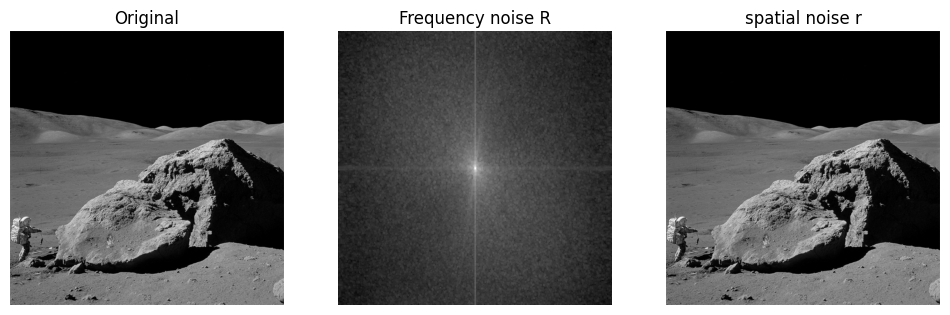

In [15]:
# Test of periodic_noise function
from skimage.morphology import square, dilation
import skimage

img = cv2.imread('./imgs/Apollo17boulder.tif', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(ncols=3, figsize=(12,6))
ax = axs.ravel()
[axi.set_axis_off() for axi in ax.ravel()]

ax[0].imshow(img, cmap='gray', vmin = 1.0, vmax = 255)
ax[0].set_title('Original')

C = np.array([[24, 44], [23, 44], [23, 43],[24, 43]]) 

r, R = periodic_noise(img.shape, C)
g = img + r
G = np.abs(np.fft.fftshift(np.fft.fft2(g)))
Gd =dilation(np.log(1+G),square(3))

ax[1].imshow(Gd, cmap='gray')
ax[1].set_title('Frequency noise R')

ax[2].imshow(g, cmap='gray', vmin = 1.0, vmax = 255)
ax[2].set_title('spatial noise r')

In [11]:
# dia 35 cband_filter

def cband_filter(shape, D0, ftype='ideal', reject = True, W = 1, n=1):
    """
    Generate a circular band filter in the frequency domain.
    """
    r,c = shape
    D0 = np.atleast_1d(D0)
    K = D0.size
    W = np.ones((K,))*W
    n = np.ones((K,))*n
    R,C = np.ogrid[:r,:c]
    D = np.sqrt((R-int(r/2))**2 + (C -int(c/2))**2)
    H = np.ones(shape)
    
    for k in range(K):
        if ftype == 'ideal':
            H[D>= D0 - W/2 | D < D0 + W/2] = 0.0
        elif ftype == 'gaussian':
            H = 1 - np.exp(-((D**2-D0**2)/(D*W))**2)
        elif (ftype == 'butterworth') | (ftype == 'btw'):
            H = 1 / (1 + ((D*W)/(D**2 - D0**2))**(2*n))
    
    if reject == False:
        H = np.abs(1-H)
    return H

C:\Users\michi\anaconda3\envs\DIP\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


IndexError: too many indices for array

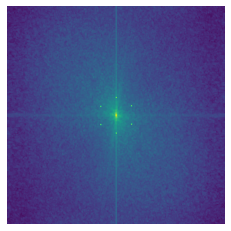

In [14]:
# Test of cband filter

import matplotlib.pyplot as plt
from skimage.morphology import square, dilation
import imageio
 
img = imageio.imread('./imgs/Apollo17boulder.tif')/255

M, N = img.shape

thetas = np.array([0, 60, 120])
D = 30*np.sqrt(2)
u = (D*np.cos(thetas*np.pi/180) + M//2).astype(int)
v = (D*np.sin(thetas*np.pi/180) + N//2).astype(int)

A = np.ones((thetas.size,))
R = np.zeros((M,N), dtype = complex)
R[u,v] = 1j * (A/2) * M * N * np.exp(0)

r = np.real(np.fft.ifft2(np.fft.ifftshift(R)))

g = img + r/3
G = np.fft.fftshift(np.fft.fft2(g))

Gd = dilation(np.log(1+np.abs(G)),square(3))
plt.figure();plt.axis('off');plt.imshow(Gd)

xy = np.array(plt.ginput(-1, show_clicks=True))
rc = xy[:,::-1]

center = np.array(img.shape)//2
rc = rc - center
D0 = (np.sum(rc**2, axis=1)**0.5).mean()
H = cband_filter(img.shape,D0,ftype='ideal',reject = True,W=3)

G2 = G*H
g2 = np.real(np.fft.ifft2(np.fft.ifftshift(G2)))

plt.subplot(411);plt.axis('off');plt.imshow(g)
plt.subplot(412);plt.axis('off');plt.imshow(Gd)
plt.subplot(413);plt.axis('off');plt.imshow(H)
plt.subplot(414);plt.axis('off');plt.imshow(g2)

In [29]:
from numpy.fft import (fft2, ifft2, fftshift)

def lpcfilter(shape, ftype='ideal', D0 = 0, n=1, center=(0,0)):
    """
    Generate low pass circular filter H in the frequency domain
    shape: shape of the filter, 
    ftype: type of the filter: 'ideal', 'gaussian' or 'butterworth', 
    DO: range of the filter frame
    n: order of the butterworth filter, 
    center: shift of the center point of the filter relative to the center of the frequency rectangle 
    """
    r,c = shape
    R,C = np.ogrid[:r,:c]
    H = np.zeros((r,c))
    D = np.sqrt((R -  r//2 - center[0])**2 + (C -  c//2 - center[1])**2)
    
    if ftype == 'ideal':
        #all pixels within radius set to 1.0
        H[D < D0] = 1.0
    elif ftype == 'gaussian':
        H = np.exp(-(D)**2/(2*(D0)**2))
    elif (ftype == 'butterworth') | (ftype == 'btw'):
        H = 1/(1 + (D/D0)**(2*n))
    
    return H
    
def hpcfilter(shape, ftype='ideal', D0 = 0, n=1, center=(0,0)):
    """
    Generate low pass circular filter H in the frequency domain
    """
    H = 1 - lpcfilter(shape, ftype = ftype, D0 = D0, n = n, center = center) 
    
    return H

In [30]:
# dia 41: cnotch_filter

def cnotch_filter(shape, centers, ftype='ideal', reject=True, D0=0, n=1):
    """
    Generate a circular notch filter in the frequency domain.
    shape:shape of the filter,
    centers: notch frequency coordinates(shape=(K,2))
    ftype: type of the filter: 'ideal' , 'gaussian', or 'butterworth' 
    reject: True or false (pass filter),
    D0: notch size(s),
    n: order(s) of the butterworth filter notches
    """
    
    D0 = np.atleast_1d(D0)
    K = D0.size
    n = np.ones((K,))*n
    H = np.ones(shape)
    
    for k in range(K):
        Hk = hpcfilter(shape, ftype=ftype, D0=D0, n=n, center=centers[k])
        H_k = hpcfilter(shape,ftype=ftype, D0=D0, n=n, centers=-centers[k])
        H *= (Hk*H_k)         
    
    if reject == False:
        H = np.abs(1-H)
    return H

C:\Users\michi\anaconda3\envs\DIP\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


IndexError: too many indices for array

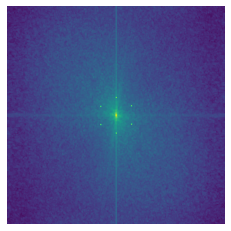

In [31]:
# Test of cnotch
G = np.fft.fftshift(np.fft.fft2(g))

Gd = dilation(np.log(1+np.abs(G)),square(3))
plt.figure();plt.axis('off');plt.imshow(Gd)

xy = np.array(plt.ginput(-1, show_clicks=True))
rc = xy[:,::-1]

center = np.array(img.shape)//2
rc = rc - center
H = cnotch_filter(img.shape,D0,ftype='ideal',reject = True,W=3)

G2 = G*H
g2 = np.real(np.fft.ifft2(np.fft.ifftshift(G2)))

plt.subplot(411);plt.axis('off');plt.imshow(g)
plt.subplot(412);plt.axis('off');plt.imshow(Gd)
plt.subplot(413);plt.axis('off');plt.imshow(H)
plt.subplot(414);plt.axis('off');plt.imshow(g2)

In [ ]:
# dia 45: custom rectangular notch filter

def rnotch_filter(shape, D0=0, angle=0, ftype='ideal', reject=True, W=1, n=1):
    r,c = shape
    D0 = np.atleast_1d(D0)
    K = D0.size
    
    angle = np.ones((K,))*angle
    W = np.ones((K,))*W
    n = np.ones((K,))*n
    
    d = 2*np.ceil(np.sqrt((r/2)**2+(c/2)**2))+1
    R,C = [x-d//2 for x in np.ogrid[:d, :d]]
    
    H = []
    
    for k in range(K):
        if ftype == 'ideal':
            Hk = np.ones((d,d))
            center = (d-1)//2
            for i in range(d):
                for j in range(d):
                    if ((i-center)**2 + (j-center)**2)**0.5 <= D0[k]:
                        Hk[i,j] = 0
        elif ftype == 'gaussian':
            Hk = np.exp(-((R**2+C**2)/(2*W[k]**2)))*np.ones((d,d))
            center = (d-1)//2
            for i in range(d):
                for j in range(d):
                    if ((i-center)**2 + (j-center)**2)**0.5 <= D0[k]:
                        Hk[i,j] = 1-Hk[i,j]

        elif (ftype == 'butterworth') | (ftype == 'btw'):
            Hk = np.ones((d,d))
            center = (d-1)//2
            for i in range(d):
                for j in range(d):
                    if ((i-center)**2 + (j-center)**2)**0.5 != 0:
                        Hk[i,j] = 1/(1+((D0[k]*W[k])/(((i-center)**2 + (j-center)**2)**0.5)**(2*n[k])))

            
        Hk = ndi.rotate(Hk,angle=angle[k],mode='reflect',reshape=False, order=1)
        
        Hk = Hk[int(d//2 - r//2):int(d//2 + r//2 + r%2), \
                int(d//2 - c//2):int(d//2 + r//2 + r%2)] 
        
        H.append(Hk)
    
    H = np.array(H).prod(axis=0)
    
    if reject == False:
        H = np.abs(1 - H)
    
    return H

In [28]:
# Test of rnotch_filter
import skimage

img = imageio.imread('./imgs/saturn_rings.tif') 
img = skimage.util.img_as_float(img) 
F = np.fft.fftshift(np.fft.fft2(img))
H = rnotch_filter(img.shape, D0=10, ftype='ideal', W=10, angle=90) 
G = F*H
g = np.real(np.fft.ifft2 (np.fft.fftshift(G))) 

fig, (ax1, ax2,ax3,ax4) = plt.subplots (nrows=4, ncols=1, figsize=(3,12), sharex = True) 

ax1.imshow (img) ;ax1.axis('off'); 
ax1.set_title('Noisy image') 
ax2.imshow (np.log(1+np.abs(F))) ;ax2.axis('off'); 
ax3.set_title('Fourier spectrum') 
ax3.imshow(np. log (1+np.abs (G))); ax3.axis('off'); 
ax3.set_title('Filtered Fourier spectrum') 
ax4.imshow (g) ;ax4.axis ('off'); 
ax4.set_title('Filtered image')

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [55]:
# dia 54: DFT filtering
import numpy as np

def dftfilt(f, H, pad=False):
    if pad:
        # Compute the padded size.
        p = np.array(H.shape)
        s = np.array(f.shape)
        shape = s + p - 1
        # Compute the center indices of the padded array.
        center = np.array([x // 2 for x in shape])
        # Zero-pad the input image.
        fpad = np.pad(f, [(center[0] - s[0] // 2, shape[0] - (center[0] + s[0] // 2)),
                          (center[1] - s[1] // 2, shape[1] - (center[1] + s[1] // 2))],
                      mode='constant', constant_values=0)
        F = np.fft.fftshift(np.fft.fft2(fpad))
    else:
        F = np.fft.fftshift(np.fft.fft2(f))
        G = F*H
        g = np.real(np.fft.ifft2 (np.fft.fftshift(G))) 
    if pad:
        # Extract the unpadded result.
        g = g[
            center[0] - s[0] // 2 : center[0] + s[0] // 2 + 1,
            center[1] - s[1] // 2 : center[1] + s[1] // 2 + 1
        ]
    return g


In [56]:
# Test of DFT filtering

img = imageio.imread('./imgs/obelix.tif')
img = skimage.util.img_as_float(img)
r,c = img.shape

H = lpcfilter((r,c), ftype='gaussian', D0=30)
g = dftfilt(img,H)

Hp = lpcfilter((r*2,c*2), ftype='gaussian', D0=30*2)
gp = dftfilt(img,Hp,pad=True)

f_ei = dftfilt(g, 1/H)
fp_ei = dftfilt(gp, 1/Hp, pad=True)

fig, axes = plt.subplots(ncols=6, figsize=(20, 5))
ax = axes.ravel()
[axi.set_axis_off() for axi in ax.ravel()]

ax[0].imshow(f_ei, cmap='gray', vmin = 1.0, vmax = 255)
ax[0].set_title('Deconvoluted (no padding)')
ax[1].imshow(fp_ei, cmap='gray', vmin = 1.0, vmax = 255)
ax[1].set_title('Deconvoluted (with padding)')

NameError: name 'gpad' is not defined